In [90]:
#Temperatur dependent defect document
# General
import numpy as np
import matplotlib.pyplot as plt
from eskild_function import *

# For handling structures and visualizing structures
from ase import Atoms
from ase.build import graphene_nanoribbon
from ase.visualize import view
from ase.visualize.plot import plot_atoms
from ase.io import read, write
import os
import os.path as osp
import sympy as sp

# For MD
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from ase.calculators.tersoff import Tersoff
from ase.constraints import FixAtoms
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.langevin import Langevin
from ase import units
from ase.neighborlist import neighbor_list

In [91]:
kind = "armchair"     # "armchair" or "zigzag"
n = 5                 # width parameter
length = 1            # periodic repetitions along z, i.e., transport direction here
vacuum = 15.0         # vacuum in non-periodic directions (Å)
bond = 1.43877067     # Optimized using C.tersoff potential discussed below

ribbon = graphene_nanoribbon(n=n,
                             m=length,
                             type=kind,
                             C_C=bond,
                             vacuum=vacuum)
ribbon.pbc = True
ribbon = sort_atoms(ribbon)
# draw_atoms(ribbon)
structure = ribbon
eta = 0.001

--- Matrix Shapes ---
H_L: (5, 5)
H_D: (10, 10)
H_R: (5, 5)
t_L (Device-Left interface): (5, 5)
t_R (Device-Right interface): (5, 5)


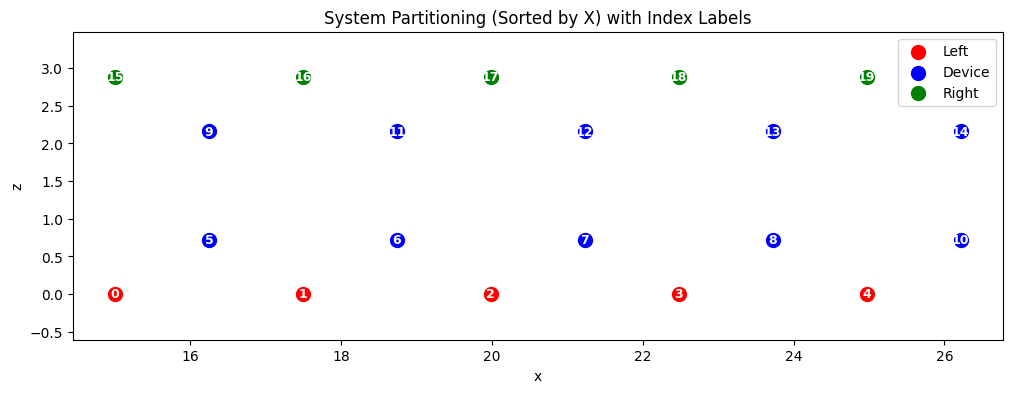

Number of atoms (and orbitals) in unit cell: 20


In [92]:
a = 1.42 # C-C bond length 

molecule = ribbon

#Sort numbering along x direction
sorted_indices = np.argsort(molecule.positions[:, 0])
sorted_positions = molecule.positions[sorted_indices]
H_gra = hamiltonian(sorted_positions)
#Then sort along z direction within same x

sorted_positions = sorted_positions[np.lexsort((sorted_positions[:, 2], sorted_positions[:, 0]))]
H_gra = hamiltonian(sorted_positions)

# Select all atoms in the molecule
indices = np.arange(len(molecule))

# Get positions from the molecule object
positions = molecule.positions[indices]

# --- New Code to Split Hamiltonian ---

# 1. Get positions of the active atoms from the molecule
# We use the 'indices' defined in the previous cell (which selects all atoms)
pos = molecule.positions[indices]

# 2. Sort atoms by their z-coordinate first, then x-coordinate (transport direction)
# This returns indices into the 'pos' (and 'H') array, not the original 'molecule' indices
x_sort_args = np.lexsort((pos[:, 0], pos[:, 2]))

# Manually swap atoms 9 and 10 as requested
x_sort_args[[9, 10]] = x_sort_args[[10, 9]]

# 3. Define Leads and Device
# Assuming the leads are the ends of the nanoribbon.
# n_lead_atoms depends on the width of the ribbon.
n_lead_atoms = 5

if len(pos) <= 2 * n_lead_atoms:
    raise ValueError(f"System too small (N={len(pos)}) to separate into Left, Device, Right with lead size {n_lead_atoms}.")

# Indices in the H matrix corresponding to each region
# (Note: These are indices 0..N-1 relative to the sub-matrix H, not the global atom indices)
idx_L = x_sort_args[:n_lead_atoms]
idx_R = x_sort_args[-n_lead_atoms:]
idx_D = x_sort_args[n_lead_atoms:-n_lead_atoms]

# 4. Extract Matrices
H_full = hamiltonian(pos) # Calculate Hamiltonian using the molecule's positions

# Hamiltonian Blocks
H_L = H_full[np.ix_(idx_L, idx_L)]      # Hamiltonian Left
H_D = H_full[np.ix_(idx_D, idx_D)]      # Hamiltonian Device
H_R = H_full[np.ix_(idx_R, idx_R)]      # Hamiltonian Right

# Hopping Matrices (Coupling between regions)
# We limit these to the interface atoms (n_lead_atoms) so they are 4x4 matrices
# t_L connects the left-most atoms of Device to Left Lead
t_L = H_full[np.ix_(idx_D[:n_lead_atoms], idx_L)]      

# t_R connects the right-most atoms of Device to Right Lead
t_R = H_full[np.ix_(idx_D[-n_lead_atoms:], idx_R)]      

print("--- Matrix Shapes ---")
print(f"H_L: {H_L.shape}")
print(f"H_D: {H_D.shape}")
print(f"H_R: {H_R.shape}")
print(f"t_L (Device-Left interface): {t_L.shape}")
print(f"t_R (Device-Right interface): {t_R.shape}")

# 5. Visualize the Partition
plt.figure(figsize=(12, 4))
plt.scatter(pos[idx_L, 0], pos[idx_L, 2], c='red', label='Left', s=100)
plt.scatter(pos[idx_D, 0], pos[idx_D, 2], c='blue', label='Device', s=100)
plt.scatter(pos[idx_R, 0], pos[idx_R, 2], c='green', label='Right', s=100)

# Add atom indices labels
for i, idx in enumerate(x_sort_args):
    plt.text(pos[idx, 0], pos[idx, 2], str(i), fontsize=9, ha='center', va='center', color='white', fontweight='bold')

plt.title("System Partitioning (Sorted by X) with Index Labels")
plt.xlabel("x")
plt.ylabel("z")
plt.legend()
plt.axis('equal')
plt.show()
Ntransport = 5 # number of repetitions in transport direction (z). To create simple [L|L|C|R|R] geometry.
pristine_structure = structure.repeat((1, 1, Ntransport))

natom_elec = len(structure)
print("Number of atoms (and orbitals) in unit cell:", natom_elec)



--- Matrix Shapes ---
H_L: (20, 20)
H_D: (60, 60)
H_R: (20, 20)
t_L (Device-Left interface): (20, 20)
t_R (Device-Right interface): (20, 20)


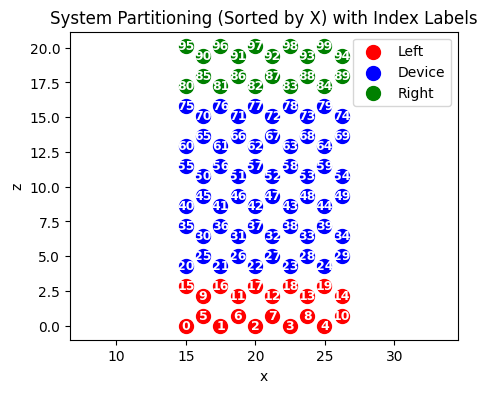

In [93]:
a = 1.42 # C-C bond length 

molecule = pristine_structure
#Sort numbering along x direction
sorted_indices = np.argsort(molecule.positions[:, 0])
sorted_positions = molecule.positions[sorted_indices]
H_gra = hamiltonian(sorted_positions)
#Then sort along z direction within same x

sorted_positions = sorted_positions[np.lexsort((sorted_positions[:, 2], sorted_positions[:, 0]))]
H_gra = hamiltonian(sorted_positions)

# Select all atoms in the molecule
indices = np.arange(len(molecule))

# Get positions from the molecule object
positions = molecule.positions[indices]

# --- New Code to Split Hamiltonian ---

# 1. Get positions of the active atoms from the molecule
# We use the 'indices' defined in the previous cell (which selects all atoms)
pos = molecule.positions[indices]

# 2. Sort atoms by their z-coordinate first, then x-coordinate (transport direction)
# This returns indices into the 'pos' (and 'H') array, not the original 'molecule' indices
x_sort_args = np.lexsort((pos[:, 0], pos[:, 2]))

# Manually swap atoms 9 and 10 as requested
x_sort_args[[9, 10]] = x_sort_args[[10, 9]]

# 3. Define Leads and Device
# Assuming the leads are the ends of the nanoribbon.
# n_lead_atoms depends on the width of the ribbon.
n_lead_atoms = 20

if len(pos) <= 2 * n_lead_atoms:
    raise ValueError(f"System too small (N={len(pos)}) to separate into Left, Device, Right with lead size {n_lead_atoms}.")

# Indices in the H matrix corresponding to each region
# (Note: These are indices 0..N-1 relative to the sub-matrix H, not the global atom indices)
idx_L = x_sort_args[:n_lead_atoms]
idx_R = x_sort_args[-n_lead_atoms:]
idx_D = x_sort_args[n_lead_atoms:-n_lead_atoms]

# 4. Extract Matrices
H_full = hamiltonian(pos) # Calculate Hamiltonian using the molecule's positions

# Hamiltonian Blocks
H_L = H_full[np.ix_(idx_L, idx_L)]      # Hamiltonian Left
H_D = H_full[np.ix_(idx_D, idx_D)]      # Hamiltonian Device
H_R = H_full[np.ix_(idx_R, idx_R)]      # Hamiltonian Right

# Hopping Matrices (Coupling between regions)
# We limit these to the interface atoms (n_lead_atoms) so they are 4x4 matrices
# t_L connects the left-most atoms of Device to Left Lead
t_L = H_full[np.ix_(idx_D[:n_lead_atoms], idx_L)]      

# t_R connects the right-most atoms of Device to Right Lead
t_R = H_full[np.ix_(idx_D[-n_lead_atoms:], idx_R)]      

print("--- Matrix Shapes ---")
print(f"H_L: {H_L.shape}")
print(f"H_D: {H_D.shape}")
print(f"H_R: {H_R.shape}")
print(f"t_L (Device-Left interface): {t_L.shape}")
print(f"t_R (Device-Right interface): {t_R.shape}")

# 5. Visualize the Partition
plt.figure(figsize=(5, 4))
plt.scatter(pos[idx_L, 0], pos[idx_L, 2], c='red', label='Left', s=100)
plt.scatter(pos[idx_D, 0], pos[idx_D, 2], c='blue', label='Device', s=100)
plt.scatter(pos[idx_R, 0], pos[idx_R, 2], c='green', label='Right', s=100)

# Add atom indices labels
for i, idx in enumerate(x_sort_args):
    plt.text(pos[idx, 0], pos[idx, 2], str(i), fontsize=9, ha='center', va='center', color='white', fontweight='bold')

plt.title("System Partitioning (Sorted by X) with Index Labels")
plt.xlabel("x")
plt.ylabel("z")
plt.legend()
plt.axis('equal')
plt.show()


In [94]:


# Reconstruct the full sorted Hamiltonian for visualization
sorted_indices = np.concatenate([idx_L, idx_D, idx_R])
H_sorted = H_full[np.ix_(sorted_indices, sorted_indices)]



In [95]:
#Parameters:
energy_range = np.linspace(-3,3, 200) * 2.7
epsilon = 0
eta = 0.0001
z = energy_range + 1j * eta

# We need to precompute self-energies first because transmission_vs_energy_one now expects them as lists
sig_L_list, g_surf_L_list = precompute_self_energies(energy_range, H_L, t_L, eta=0.0001)
sig_R_list, g_surf_R_list = precompute_self_energies(energy_range, H_R, t_R, eta=0.0001)

trans_val_perfect = transmission_vs_energy_one(H_D, energy_range, sig_R_list, sig_L_list, None, None, eta=0.0001)

In [96]:
#Giving atom 47 a on-site energy of -2 eV
H_defected = H_full.copy()
H_defected[47,47] = -2.0

In [97]:
#Parameters:
energy_range = np.linspace(-3,3, 200) * 2.7
epsilon = 0
eta = 0.0001
z = energy_range + 1j * eta

# Load parameter file
# Adjusted to be cross-platform (Linux/Windows) and handle different CWDs
potential_file = "C.tersoff"
if not osp.exists(potential_file):
    potential_file = osp.join("TemperatureDependantTransport", "C.tersoff")
    
calc = Tersoff.from_lammps(potential_file)

# Set up calculator
structure.calc = calc # Attach Tersoff calculator based on parameters in C.tersoff

# Now based on this interatomic potential, we can get total energies and forces:
energy = structure.get_potential_energy()
forces = structure.get_forces()

<AxesSubplot: xlabel='z, Å', ylabel='x, Å'>

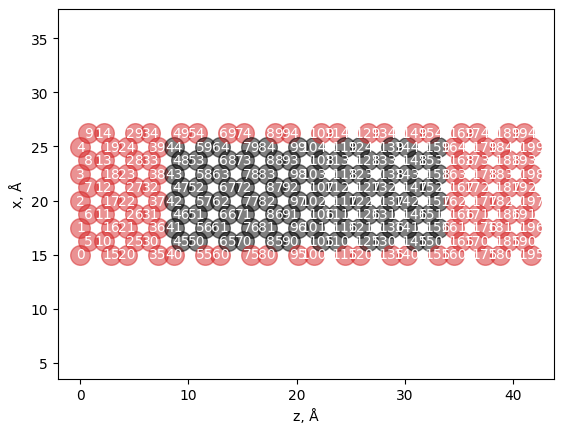

In [98]:
# First create longer [L|L|C|R|R] structure where L and R are fixed and the length of the central part (C) can be varied.
natoms_elec = len(structure)
xyz = structure.positions
lattice = structure.cell[:]
ntile = 10 # 
tiledir = 2 # tile in z
for n in range(1, ntile):
    xyz = np.concatenate((xyz, structure.positions + lattice[tiledir, :]*n))
tilemat = np.eye(3, dtype=int) # repetition matrix
tilemat[tiledir,tiledir] = ntile
lattice = tilemat @ lattice
natoms = len(xyz)
md_structure = Atoms(natoms*["C"], positions=xyz, cell=lattice, pbc=True) # Create a ASE atoms object of the repeated structure

# Fix electrode
fixed_uc = 2 # The number of electrode unit cells to fix on each side.
leftinds = list(range(0,natoms_elec*fixed_uc)) # Fix the two first unit cells
rightinds = list(range(natoms-natoms_elec*fixed_uc,natoms)) # Fix the two last unit cells

# ... and edges to simplify MD
cutoff = 1.5 # Nearest neighbor distance is d0 = 1.43877067 Å
bulk_nneighbors = 3 # In bulk graphene there are 3 nearest neighbors

i, j = neighbor_list("ij", md_structure, cutoff)
counts = np.bincount(i, minlength=len(md_structure))
edgeinds = list(np.where(counts < bulk_nneighbors)[0])

allinds = np.unique(leftinds+rightinds+edgeinds)
fixed = FixAtoms(mask=allinds)
md_structure.set_constraint(fixed) # Fix L and R electrode
draw_atoms(md_structure) # Red atoms are fixed, grey atoms are free to move

In [ ]:
filepath = "C:\\Users\\eskil\\OneDrive\\DTU\\5.sem\\Quantum_Electronics\\Exercises\\md.xyz"
md_traj = read(filepath, index=":") # Load trajectory from xyz

In [100]:
# --- Run the calculation ---
# Use every 2nd frame for speed
rad = md_traj[400:600:2]
sig_L_list, g_suf_L_list = precompute_self_energies(energy_range, H_L, t_L, eta=0.0001)
sig_R_list, g_suf_R_list = precompute_self_energies(energy_range, H_R, t_R, eta=0.0001)
# list_defected = [84, 83, 82]
list_defected = [[99,98,97]]
energy_change = [-2.0]
avg_list_defected = []

# Define output directory
output_dir = "Defected_tranmission_data"
if not osp.exists(output_dir):
    # Try looking in subfolder if cwd is parent
    potential_sub = osp.join("TemperatureDependantTransport", "Defected_tranmission_data")
    if osp.exists(potential_sub):
        output_dir = potential_sub
    else:
        # If neither exists, create it in current directory (or handle as appropriate)
        # But if we are in parent, we might want to create in submodule.
        # Let's stick to current directory relative if not found.
        os.makedirs(output_dir, exist_ok=True)

for i, e_change in zip(list_defected, energy_change):
    filename = osp.join(output_dir, f"Defected_tranmission_atom_{i}_with_energy_change_{e_change}.csv")
    recalculate = True
    
    if osp.exists(filename):
        print(f"File {filename} exists. Loading data...")
        try:
            # Load existing data
            loaded_data = np.loadtxt(filename, delimiter=',', skiprows=1)
            # Assuming column 1 is Transmission
            avg_trans_defected = loaded_data[:, 1]
            avg_list_defected.append(avg_trans_defected)
            recalculate = False
        except Exception as e:
             print(f"Error loading file: {e}. Proceeding to recalculate.")
    
    if recalculate:
        print(f"Calculating transmission for defect at atom {i} with energy change {e_change}...")
        # Parallel calculation using the new defected function
        results_defected = Parallel(n_jobs=-1)(
            delayed(process_frame_defected)(frame, energy_range, sig_L_list, sig_R_list, 0.0001, [i], e_change) 
            for frame in tqdm(rad))
        trans_list = results_defected
        avg_trans_defected = np.mean(trans_list, axis=0)
        avg_list_defected.append(avg_trans_defected)
        
        print(f"Saving to {filename}...")
        np.savetxt(filename, np.column_stack((energy_range / 2.7, avg_trans_defected)), delimiter=',', header='Energy(eV),Transmission', comments='')

File Defected_tranmission_data\Defected_tranmission_atom_[99, 98, 97]_with_energy_change_-2.0.csv exists. Loading data...


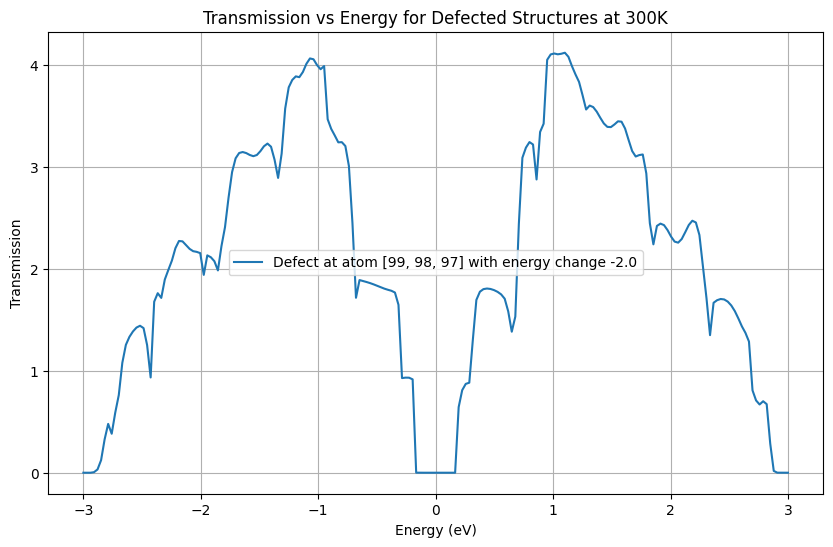

In [101]:
#Load data
data = []

# Re-determine directory logic or reuse logic if running cells sequentially
output_dir = "Defected_tranmission_data"
if not osp.exists(output_dir):
    potential_sub = osp.join("TemperatureDependantTransport", "Defected_tranmission_data")
    if osp.exists(potential_sub):
        output_dir = potential_sub

for i, e_change in zip(list_defected, energy_change):
    # Skip the header row using skiprows=1
    filepath = osp.join(output_dir, f"Defected_tranmission_atom_{i}_with_energy_change_{e_change}.csv")
    data.append(np.loadtxt(filepath, delimiter=',', skiprows=1))
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(len(data)):
    energy = data[i][:, 0]
    transmission = data[i][:, 1]
    ax.plot(energy, transmission, label='Defect at atom {} with energy change {}'.format(list_defected[i], energy_change[i]))
# ax.plot(energy, trans_val_perfect, 'k--', label='Pristine Structure')
ax.set_xlabel('Energy (eV)')
ax.set_ylabel('Transmission')
temp = 300
ax.set_title(f'Transmission vs Energy for Defected Structures at {temp}K')
ax.grid()
ax.legend()
plt.show()

In [102]:
#################################################
#Current transport visualization
################################################
from ase.visualize import view
from ase.build import graphene
from ase.io import read
from ase.visualize.plot import plot_atoms # view inside jupyter
from ase.io import write
from my_plot_ase_xy import *
from my_nglview_functions import *

<AxesSubplot: xlabel='z, Å', ylabel='x, Å'>

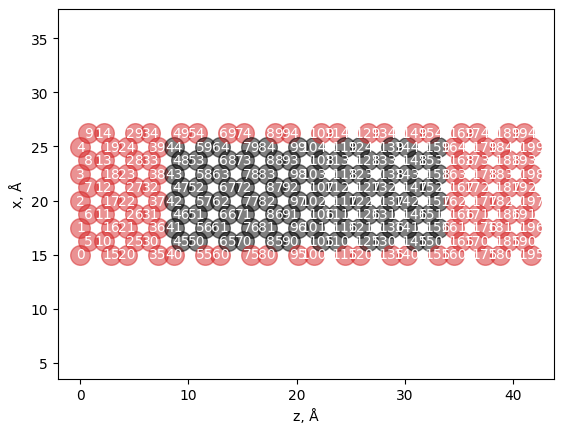

In [103]:
draw_atoms(md_structure)

In [104]:
def SplitHam(H,nL,nR):
        no = len(H)
        nd = no - nL - nR
        if(nd < 1):
            print("Setup error: number of device sites = ", nd)
            print("Use [nL|nL|nd|nR|nR] setup")
            return
    
        hL0 = H[0:nL,0:nL]
        hL = H[nL:2*nL,nL:2*nL]
        if not np.allclose(hL,hL0):
            print("Warning: Repetition-check nL")
        VLT = H[0:nL,nL:2*nL] # left-to-right hop 
        hD = H[nL:nL+nd,nL:nL+nd]
        hR0 = H[-2*nR:-nR,-2*nR:-nR]
        hR = H[-nR:,-nR:]
        if not np.allclose(hR,hR0):
            print("Warning: Repetition-check nR")
        VRT = H[-2*nR:-nR,-nR:] # Left-to-right hop 
        fig, ax = plt.subplots()
        ax.spy(Hbig)
        return hL,VLT.T,hR,VRT.T,hD
def selfenergy(h, hs, V, En):
    #helpful variable
    nl = len(h)
    eta = 0.001
    tol = 0.000001
    #initial matrices
    b = V
    e = h.copy()
    a = V.conj().T
    es = hs.copy()
    z = En+ 1j*eta
    #loop over iterations until all elements in hopping hamiltonian are small  ie. when at large distance
    while np.max(np.absolute(b)) > tol:
        # calculate the terms in the iterative matrix e. 76-79 in Note
        g = np.linalg.inv(z*np.eye(nl) - e)
        agb = np.matmul(np.matmul(a,g),b) #Else you calculate same matrix two times
        e = e + agb + np.matmul(np.matmul(b,g),a)
        es = es + agb
        a = np.matmul(np.matmul(a,g),a)
        b = np.matmul(np.matmul(b,g),b)
    #calculate both self energy, bulk and device greens function
    SR = es - hs
    SL = e - h - SR
    G0 = np.linalg.inv(z*np.eye(nl) - (h + SR))
    gb = np.linalg.inv(z*np.eye(nl) - (hs + SR + SL))
    return gb, G0, SL, SR
def transmission(hL, hR, hD, vL, vR, En): 
    Eta = 0.0001
    nL,nR,nD = len(hL),len(hR),len(hD)
    selfL = np.zeros((nD,nD),dtype='complex')
    selfR = np.zeros((nD,nD),dtype='complex')
    nL,nR,nD = len(hL),len(hR),len(hD)
    SL = selfenergy(hL, hL, vL, En)[2] # left
    SR = selfenergy(hR, hR, vR, En)[3] # right
    selfL[0:nL,0:nL] = SL
    selfR[nD-nR:nD,nD-nR:nD] = SR
    #return selfL,selfR
    GD =  np.linalg.inv((En + 1j*Eta)*np.eye(len(hD)) - hD - selfL - selfR)
    gammaL = 1j*(selfL - selfL.conj().T)
    gammaR = 1j*(selfR - selfR.conj().T)
    #take the trace of the matrix product
    AL = np.matmul(np.matmul(GD,gammaL),GD.conj().T)
    T = np.trace(np.matmul(AL,gammaR))
    return T.real , GD, AL

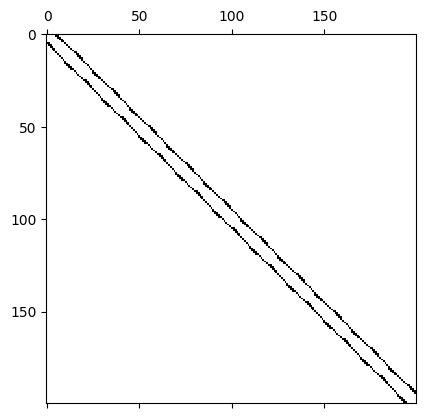

In [105]:
#Number of atoms in left/right lead unit cell
nl = natom_elec
nr = nl
sorted_atoms_Big = md_structure
positions = sorted_atoms_Big.get_positions()
Hbig = hamiltonian(positions)
hL,VL,hR,VR,HD = SplitHam(Hbig,nl,nr)
HD_defected = HD.copy()
defected_indices = np.linspace(31,159,11).astype(int)
# defected_indices = [77,72,137,142]
for i in defected_indices:
    HD_defected[i,i] = -2.0


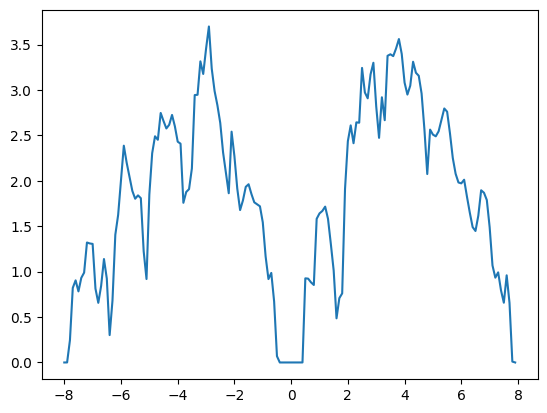

In [106]:
Tdat = []
Energies = np.arange(-8,8,0.1)
for energy in Energies:
    T,_,_ = transmission(hL,hR,HD_defected,VL,VR,energy)
    Tdat.append(T.real)
Tdat = np.array(Tdat)
plt.plot(Energies,Tdat)

In [107]:
atoms_dev = sorted_atoms_Big[nl:-nr]
Energy = -3.  ### Choose energy
T_defected,_,AL_defected = transmission(hL,hR,HD_defected,VL,VR,Energy)
T_pristine,_,AL = transmission(hL,hR,HD,VL,VR,Energy)
PDOS_defected = np.diagonal(AL_defected).real
e_d, v_d = np.linalg.eigh(AL_defected)
atol = 0.001
aL = e_d[np.abs(e_d)>atol]
psiL = v_d[:,np.abs(e_d)>atol]
nstates = len(aL)
print("We will have ", nstates," propagating waves each with DOS:",aL)
PDOS = np.diagonal(AL).real
e, v = np.linalg.eigh(AL)
atol = 0.001
aa = e[np.abs(e)>atol]
psia = v[:,np.abs(e)>atol]
nstates_pristine = len(aa)
print("We will have ", nstates_pristine," propagating waves each with DOS:",aa)



We will have  5  propagating waves each with DOS: [ 6.21884685  7.25837582  9.28303662 13.12663028 20.8288844 ]
We will have  5  propagating waves each with DOS: [ 6.09089345  6.14793718  7.80636019  8.2342877  23.96644626]


(<Figure size 600x600 with 2 Axes>,
 <AxesSubplot: xlabel='z (Å)', ylabel='-x (Å)'>)

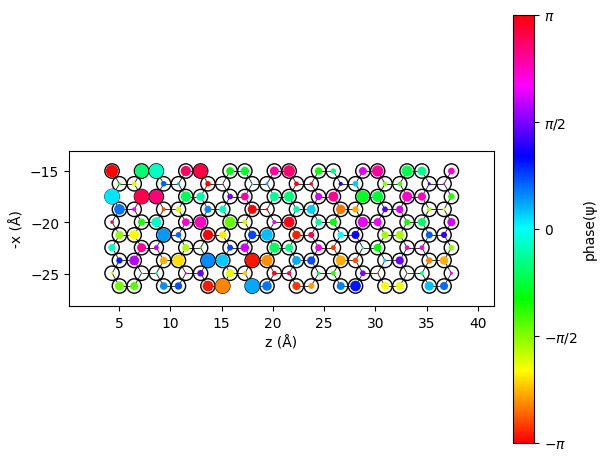

In [108]:
istate = 4
if istate > nstates:
    print("Choose istate <",nstates)
psi=psiL.T[istate]
Jstate = np.imag(np.outer((psi).conj(),psi)*HD)
plot_ase_xy(atoms_dev,psi=psi, wf_scale=5, atom_radius=0.7,wf_alpha=1)

(<Figure size 600x600 with 1 Axes>,
 <AxesSubplot: xlabel='z (Å)', ylabel='-x (Å)'>)

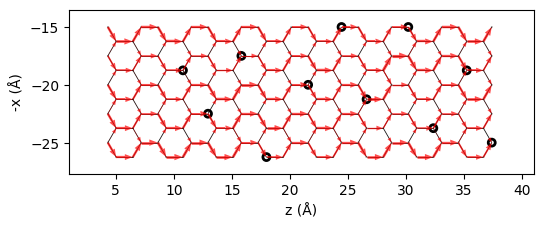

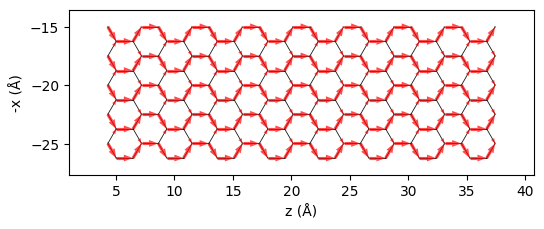

In [109]:
import importlib
import my_plot_ase_xy
importlib.reload(my_plot_ase_xy)
from my_plot_ase_xy import plot_ase_xy

Jtot_defected = np.imag(AL_defected*HD_defected)  ### Note element-wise multiplication!
# Use highlight_radius=0.3 to ensure the highlighted atoms are visible
plot_ase_xy(atoms_dev, J = Jtot_defected,current_scale=1.5,lw_min=0.0001, lw_max=1.5, atom_radius=0.01, highlight_atoms=defected_indices, highlight_radius=0.3)
Jtot_pristine = np.imag(AL*HD)  ### Note element-wise multiplication!
plot_ase_xy(atoms_dev, J = Jtot_pristine,current_scale=1.5,lw_min=0.0001, lw_max=1.5, atom_radius=0.01)